<div style="border:solid green 3px; padding: 20px">
<b>🥇 Алексей, спасибо за доработки, проект принят, молодец!</b>
    
Ты провел очень хорошую работу над ошибками! Уверен, ты обязательно достигнешь своей цели! Успехов в дальнейшем обучении! 🙂
    

# Анализ сервиса аренды самокатов GoFast

### Введение.
Цель проекта проанализировать данные о пользователях и их поездках самокатов из нескольких городов. Для выполнения этой цели осуществим подготовку и предобработку данных чтобы ответить на вопросы:
- Тратят ли пользователи с подпиской больше времени на поездки?
Проверим гипотезу: пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе.


- Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 
Проверим гипотезу: пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку.
- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
Проверим гипотезу: помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки
без подписки


Описание данных:

Пользователи — users_go.csv

user_id — уникальный идентификатор пользователя
name — имя пользователя
age — возраст
city — город
subscription_type — тип подписки (free, ultra)
Поeздки — rides_go.csv

user_id — уникальный идентификатор пользователя
distance — расстояние, которое пользователь проехал в текущей сессии (в метрах)
duration — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
date — дата совершения поездки
Подписки — subscriptions_go.csv

subscription_type — тип подписки
minute_price — стоимость одной минуты поездки по данной подписке
start_ride_price — стоимость начала поездки
subscription_fee — стоимость ежемесячного платежа


In [1]:


import pandas as pd
import warnings
import numpy as np
warnings.simplefilter('ignore')
from scipy import stats as st

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg' 


from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

#### Шаг 1. Загрузка данных

In [2]:
try:
    users = pd.read_csv('/datasets/users_go.csv', sep=',')
except:
    users = pd.read_csv('users_go.csv', sep=',')
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [3]:

try:
    rides = pd.read_csv('/datasets/rides_go.csv', sep=',', parse_dates=['date'])
except:
    rides = pd.read_csv('rides_go.csv', sep=',', parse_dates=['date'])
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [4]:
rides.dtypes

user_id              int64
distance           float64
duration           float64
date        datetime64[ns]
dtype: object

In [5]:
try:
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv', sep=',')
except:
    subscriptions = pd.read_csv('subscriptions_go.csv', sep=',')

subscriptions.head(10)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [6]:
#функция для получения общей информации о датафрейме
def df_inf(data): 
    display(data.head())
    display(data.describe())
    display(data.info())
    for column in data.columns:
        display()
        display(column)
        display(data[column].unique())
    display(data[data.duplicated()])
    display(pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm') )

In [7]:
df_inf(rides)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


None

'user_id'

array([   1,    2,    3, ..., 1532, 1533, 1534])

'distance'

array([4409.9191402 , 2617.59215346,  754.15980696, ..., 3826.1855073 ,
       2902.30866066, 2371.71119224])

'duration'

array([25.59976897, 15.81687145,  6.23211346, ..., 18.43505138,
       16.6743622 , 15.89391697])

'date'

array(['2021-01-01T00:00:00.000000000', '2021-01-18T00:00:00.000000000',
       '2021-04-20T00:00:00.000000000', '2021-08-11T00:00:00.000000000',
       '2021-08-28T00:00:00.000000000', '2021-10-09T00:00:00.000000000',
       '2021-10-19T00:00:00.000000000', '2021-11-06T00:00:00.000000000',
       '2021-11-14T00:00:00.000000000', '2021-11-22T00:00:00.000000000',
       '2021-12-14T00:00:00.000000000', '2021-12-22T00:00:00.000000000',
       '2021-03-15T00:00:00.000000000', '2021-03-18T00:00:00.000000000',
       '2021-03-23T00:00:00.000000000', '2021-04-08T00:00:00.000000000',
       '2021-04-13T00:00:00.000000000', '2021-06-20T00:00:00.000000000',
       '2021-07-02T00:00:00.000000000', '2021-07-18T00:00:00.000000000',
       '2021-08-03T00:00:00.000000000', '2021-10-27T00:00:00.000000000',
       '2021-12-18T00:00:00.000000000', '2021-01-31T00:00:00.000000000',
       '2021-02-24T00:00:00.000000000', '2021-02-26T00:00:00.000000000',
       '2021-04-12T00:00:00.000000000', '2021-05-07

,user_id,distance,duration,date


,0
user_id,0.000000
distance,0.000000
duration,0.000000
date,0.000000


In [8]:
df_inf(users)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

'user_id'

array([   1,    2,    3, ..., 1532, 1533, 1534])

'name'

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

'age'

array([22, 31, 20, 26, 28, 25, 23, 21, 18, 27, 24, 29, 32, 14, 19, 30, 17,
       12, 35, 33, 13, 15, 37, 16, 34, 38, 36, 39, 43])

'city'

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

'subscription_type'

array(['ultra', 'free'], dtype=object)

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


,0
user_id,0.000000
name,0.000000
age,0.000000
city,0.000000
subscription_type,0.000000


In [9]:
df_inf(subscriptions)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


,minute_price,start_ride_price,subscription_fee
count,2.000000,2.000000,2.000000
mean,7.000000,25.000000,99.500000
std,1.414214,35.355339,140.714249
min,6.000000,0.000000,0.000000
25%,6.500000,12.500000,49.750000
50%,7.000000,25.000000,99.500000
75%,7.500000,37.500000,149.250000
max,8.000000,50.000000,199.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

'subscription_type'

array(['free', 'ultra'], dtype=object)

'minute_price'

array([8, 6])

'start_ride_price'

array([50,  0])

'subscription_fee'

array([  0, 199])

,subscription_type,minute_price,start_ride_price,subscription_fee


,0
subscription_type,0.000000
minute_price,0.000000
start_ride_price,0.000000
subscription_fee,0.000000


### Вывод
 Была проведена загрузка и изучение данных. Данные загрузились корректно , явные ошибки при чтении отсутствуют.  Явных аномалий и проблем в данных не замечено. При изучении  данных замечено , что данные за период времени 2021 год, основные пользователи - люди от 20 до 30 лет. Пропусков в данных нет.
 

#### Шаг 2. Предобработка данных

Шаг 2. Предобработка данных
2.1 Приведите столбец date к типу даты pandas.
2.2 Создайте новый столбец с номером месяца на основе столбца date.
2.3 Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют.

In [10]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


2.1 привел сразу при загрузке данных

In [11]:
# 2.2 Создайте новый столбец с номером месяца на основе столбца date.
rides['month'] = pd.DatetimeIndex(rides['date']).month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [12]:
rides['date'].min()

Timestamp('2021-01-01 00:00:00')

In [13]:
rides['date'].max()

Timestamp('2021-12-30 00:00:00')

2.3 Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют.
Проверил на дубликаты в предыдущем пункте с помощью функции df_inf. пропусков и аномалий не обнаружил, дубликаты удалил

In [14]:
users.duplicated().sum()

31

In [15]:
users=users.drop_duplicates()
users.info

<bound method DataFrame.info of       user_id        name  age            city subscription_type
0           1        Кира   22          Тюмень             ultra
1           2   Станислав   31            Омск             ultra
2           3     Алексей   20          Москва             ultra
3           4  Константин   26  Ростов-на-Дону             ultra
4           5       Адель   28            Омск             ultra
...       ...         ...  ...             ...               ...
1529     1530   Ростислав   29            Сочи              free
1530     1531      Никита   25       Пятигорск              free
1531     1532     Алексей   26          Тюмень              free
1532     1533      Степан   22       Краснодар              free
1533     1534     Альберт   25       Краснодар              free

[1534 rows x 5 columns]>

Удалил явные дубликаты

###### Вывод:

Пропущенных данных в таблицах нет.

Дубликаты имеются среди пользователей, удалил строки-дубликаты.

Добавил столбец month с номер месяца.

#### Шаг 3. Исследовательский анализ данных


Опишите и визуализируйте общую информацию о пользователях и поездках:
3.1 частота встречаемости городов;
3.2 соотношение пользователей с подпиской и без подписки;
3.3 возраст пользователей;
3.4 расстояние, которое пользователь преодолел за одну поездку;
3.5 продолжительность поездок.

In [16]:
#3.1 
cities_freq =users['city'].value_counts().sort_values(ascending=True)
cities_freq

Москва            168
Тюмень            180
Омск              183
Сочи              189
Краснодар         193
Ростов-на-Дону    198
Екатеринбург      204
Пятигорск         219
Name: city, dtype: int64

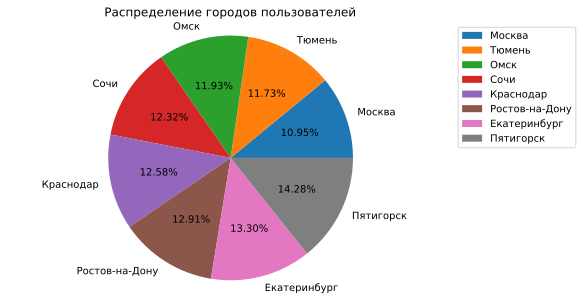

In [17]:
fig1, ax1 = plt.subplots()
 
wedges, texts, autotexts = ax1.pie(cities_freq, labels=cities_freq.index, autopct='%1.2f%%')
ax1.axis('equal')
ax1.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.title("Распределение городов пользователей")
plt.show()

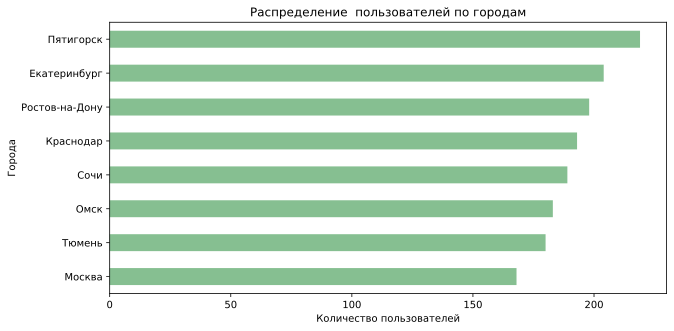

In [18]:

ax = cities_freq.plot(kind='barh', color='#86bf91', figsize=(10,5))
plt.title('Распределение  пользователей по городам')
plt.xlabel('Количество пользователей')
plt.ylabel('Города');

In [19]:
#3.2
users_ratio=users['subscription_type'].value_counts().sort_values(ascending=False)
users_ratio

free     835
ultra    699
Name: subscription_type, dtype: int64

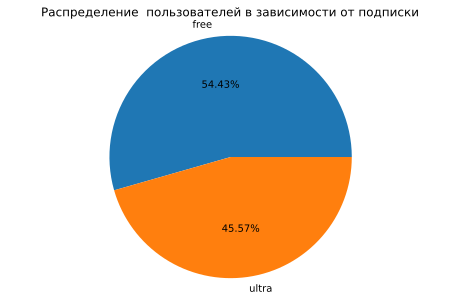

In [20]:
fig1, ax1 = plt.subplots()
 
wedges, texts, autotexts = ax1.pie(users_ratio, labels=users_ratio.index, autopct='%1.2f%%')
ax1.axis('equal')
plt.title('Распределение  пользователей в зависимости от подписки')

plt.show()

3.3 возраст пользователей

In [21]:
users

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1529,1530,Ростислав,29,Сочи,free
1530,1531,Никита,25,Пятигорск,free
1531,1532,Алексей,26,Тюмень,free
1532,1533,Степан,22,Краснодар,free


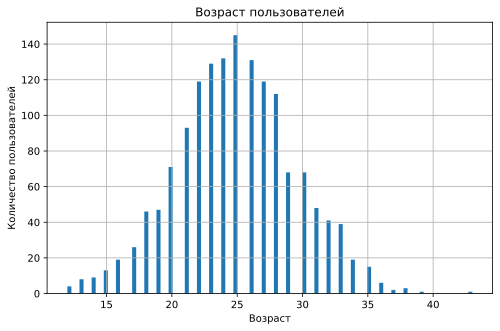

In [22]:
users['age'].hist(bins=100)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей');

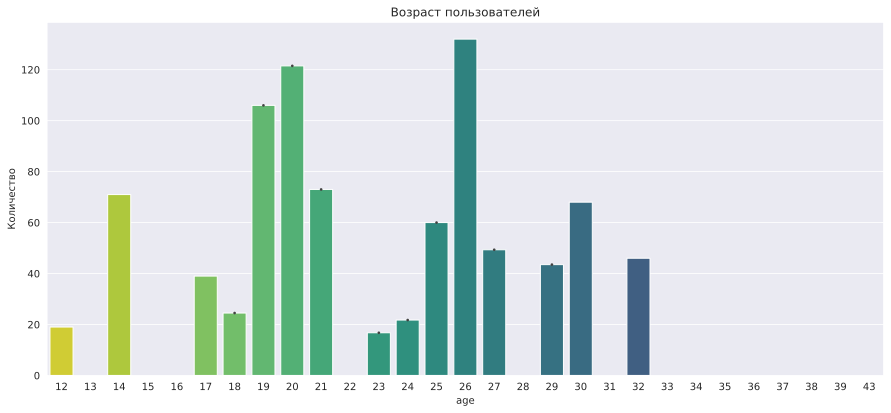

In [23]:
# другой способ предтавления возраста пользователей
plt.figure(figsize=(15,6.5))
sns.set_style('darkgrid')
g = sns.barplot(data=users, x='age',y=users['age'].value_counts(), ci=False, palette='viridis_r')
plt.ylabel('Количество')
plt.title('Возраст пользователей')
plt.show()

In [24]:
users.describe()

,user_id,age
count,1534.000000,1534.000000
mean,767.500000,24.903520
std,442.971971,4.572367
min,1.000000,12.000000
25%,384.250000,22.000000
50%,767.500000,25.000000
75%,1150.750000,28.000000
max,1534.000000,43.000000


3.4 расстояние, которое пользователь преодолел за одну поездку; 3.5 продолжительность поездок.

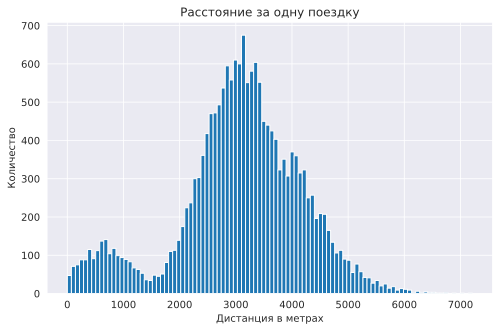

In [25]:
rides['distance'].hist(bins=100)
plt.ylabel('Количество')
plt.xlabel('Дистанция в метрах')
plt.title('Расстояние за одну поездку');

3.5 продолжительность поездок.

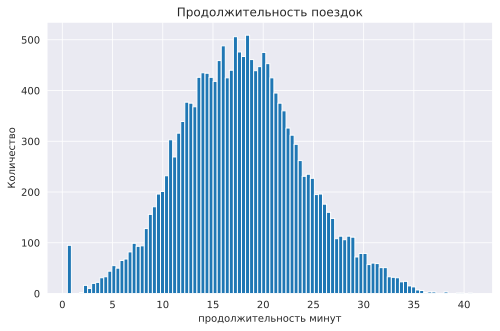

In [26]:
rides['duration'].hist(bins=100)
plt.ylabel('Количество')
plt.xlabel('продолжительность минут')
plt.title('Продолжительность поездок');

In [27]:
rides.query('duration<4')

,user_id,distance,duration,date,month
5952,635,266.123499,3.760353,2021-12-23,12
6531,701,4196.445201,0.500000,2021-08-31,8
6570,704,4830.824371,0.500000,2021-10-14,10
6680,712,4684.004397,0.500000,2021-03-04,3
6691,712,23.963062,2.053251,2021-11-22,11
...,...,...,...,...,...
17722,1511,87.430522,3.218576,2021-01-21,1
17787,1515,559.973769,3.599925,2021-11-15,11
17802,1516,393.696926,2.874882,2021-07-28,7
17909,1524,4103.998874,0.500000,2021-06-18,6


In [28]:
rides.query('duration<4 and distance> 1000')

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


Обнаружены странные поездки где время одинаковое 0.5 секунды а дистанция довольно значительная. Это явно выбросы удалю эти строчки

In [29]:
bad_index =rides.query('duration<4 and distance> 1000').index
rides = rides.drop (index=bad_index ) 


#### Шаг 4. Объединение данных

###### Вывод

Частота встречаемости городов:

Количество пользователей по городам распределено более менее равномерно.

Соотношение пользователей с подпиской и без подписки:

Количество пользователей с подпиской и без более менее равномерно. Пользователей, использующих бесплатную подписку чуть больше - ~ 54% от общего числа пользователей процент пользователей с платной подпиской  ~46%.

Возраст пользователей:

Минимальный возраст пользователей 12 лет.
максимальный - 43 года
Большая часть пользователей попадает в   промежуток от 20 до 30 лет.

Расстояние, которое пользователь преодолел за одну поездку:

Самая короткая дистанция - 0.86 км
Самая длинная - 7.2 км
Большая часть пользователей попадает в   промежуток от 2.5 км до 4 км.

Продолжительность поездок:

Самые короткие поездки - по пол минуты. Скорее всего являются выбросом , причиной таких поездок может быть либо техническая неисравность самоката либо какая то проблема с выгрузкой данных.

Самая длинная поездка заняла 40 минут.
Большая часть пользователей попадает в   промежуток 13 - 22 минут.

4.1 Объедините данные о пользователях, поездках и подписках в один датафрейм

In [30]:
users_merged = users.merge(rides, on='user_id')
users_merged


,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...,...,...,...,...
17968,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11
17969,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11
17970,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11
17971,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11


In [31]:
users_merged_all=users_merged.merge(subscriptions, on='subscription_type')
users_merged_all

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
17969,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
17970,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
17971,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [32]:
display(users.shape)
display(rides.shape)
display(subscriptions.shape)
display(users_merged_all.shape)

(1534, 5)

(17973, 5)

(2, 4)

(17973, 12)

4.2 Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1:
c данными о пользователях без подписки;
с данными о пользователях с подпиской.

In [33]:
users_with_subscription=users_merged_all.query('subscription_type=="ultra"')
users_with_subscription

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


In [34]:
users_without_subscription=users_merged_all.query('subscription_type=="free"')
users_without_subscription

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
17969,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
17970,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
17971,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


4.3 Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.

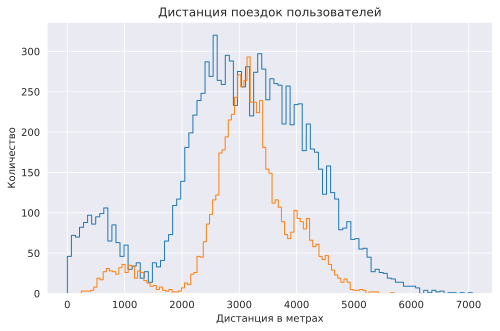

In [35]:

users_without_subscription['distance'].hist(bins=100,histtype='step')
users_with_subscription['distance'].hist(bins=100,histtype='step')
plt.title('Дистанция поездок пользователей')
plt.ylabel('Количество')
plt.xlabel('Дистанция в метрах');

Из графиков видно что пользователи без подписки катаются ощутимо дольше чем пользователи без подписки , что не может обьясняться различием в количестве пользовталей с подпиской и без. Также видно что выброс данных с нулевым растоянием принадлежит пользователям без подписки. Скорее всего у этих пользователей возникла сложность с поездной из за недостатка опыта в использовании приложения.

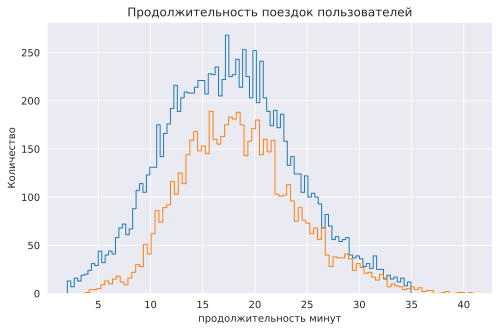

In [36]:
users_without_subscription['duration'].hist(bins=100,histtype='step')
users_with_subscription['duration'].hist(bins=100,histtype='step')
plt.title('Продолжительность поездок пользователей')
plt.ylabel('Количество')
plt.xlabel('продолжительность минут');

Из графиков видно что пользователи без подписки катаются немного больше времени так как график смещен немного влево. Также видно что выброс данных с коротким временем поездки принадлежит пользователям без подписки. Таким образом предварительно можно заметить что в деле сохранения ресурса самоката пользователи с подпиской выгоднее так как проезжают меньшее расстояние за то же время.

#### Вывод

В ходе работы были обьеденены датафреймы о пользователях, поездках и тарифах. Затем пользователи с подпиской и без были разделены на два датафрейма . 
У бесплатного тарифа среднее время поездки несколько меньше чем  у платного а расстояние наоборот больше. Так у бесплатного тарифа время поездки составляет от 10 до 30 минут, и проезжают от 2 до 6 км. А у платного тарифа время поездки  составляет от 15 до 25 минут. И очень много пользовтаелей проезжают близко  к 3 км , что является оптимальным для износа самоката 


#### Шаг 5. Подсчёт выручки

5.1

In [37]:
users_merged_all['duration'] = np.ceil(users_merged_all['duration']) 
users_merged_all

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,Альберт,25,Краснодар,free,3781.098080,20.0,2021-11-04,11,8,50,0
17969,1534,Альберт,25,Краснодар,free,2840.423057,22.0,2021-11-16,11,8,50,0
17970,1534,Альберт,25,Краснодар,free,3826.185507,19.0,2021-11-18,11,8,50,0
17971,1534,Альберт,25,Краснодар,free,2902.308661,17.0,2021-11-27,11,8,50,0


In [38]:

users_merged_all_pivot=users_merged_all.pivot_table(index=['user_id','month'], values=['distance','duration','name', 'subscription_type','minute_price','start_ride_price','subscription_fee'],aggfunc={'distance': sum, 
                                      'duration' : sum, 
                                      'name' : len , 
                                      'subscription_type' : min,
                                      'minute_price': 'first',
                                      'start_ride_price':'first',
                                      'subscription_fee':'first'})


In [39]:
display(users_merged_all_pivot)


distance  duration  minute_price  name  start_ride_price  \
user_id month                                                                 
1       1       7027.511294      42.0             6     2                 0   
        4        754.159807       7.0             6     1                 0   
        8       6723.470560      46.0             6     2                 0   
        10      5809.911100      32.0             6     2                 0   
        11      7003.499363      56.0             6     3                 0   
...                     ...       ...           ...   ...               ...   
1534    6       3409.468534      26.0             8     2                50   
        8       7622.453034      48.0             8     2                50   
        9       4928.173852      23.0             8     1                50   
        11     13350.015305      78.0             8     4                50   
        12      2371.711192      16.0             8     1                50   

               subscription_fee subscription_type  
user_id month                                      
1       1                   199             ultra  
        4                   199             ultra  
        8                   199             ultra  
        10                  199             ultra  
        11                  199             ultra  
...                         ...               ...  
1534    6                     0              free  
        8                     0              free  
        9                     0              free  
        11                    0              free  
        12                    0              free  

[11300 rows x 7 columns]

In [40]:
users_merged_all_pivot.columns=['distance','duration','minute_price','count','start_ride_price','subscription_fee','subscription_type']

users_merged_all_pivot

distance  duration  minute_price  count  start_ride_price  \
user_id month                                                                  
1       1       7027.511294      42.0             6      2                 0   
        4        754.159807       7.0             6      1                 0   
        8       6723.470560      46.0             6      2                 0   
        10      5809.911100      32.0             6      2                 0   
        11      7003.499363      56.0             6      3                 0   
...                     ...       ...           ...    ...               ...   
1534    6       3409.468534      26.0             8      2                50   
        8       7622.453034      48.0             8      2                50   
        9       4928.173852      23.0             8      1                50   
        11     13350.015305      78.0             8      4                50   
        12      2371.711192      16.0             8      1                50   

               subscription_fee subscription_type  
user_id month                                      
1       1                   199             ultra  
        4                   199             ultra  
        8                   199             ultra  
        10                  199             ultra  
        11                  199             ultra  
...                         ...               ...  
1534    6                     0              free  
        8                     0              free  
        9                     0              free  
        11                    0              free  
        12                    0              free  

[11300 rows x 7 columns]

In [41]:
def revenue_1(df):
    rev= df['count']* df['start_ride_price'] + df['duration']*df['minute_price']+df['subscription_fee']
    return rev



5.2 

In [42]:
users_merged_all_pivot['revenue']=users_merged_all_pivot.apply(revenue_1,axis=1)
users_merged_all_pivot

distance  duration  minute_price  count  start_ride_price  \
user_id month                                                                  
1       1       7027.511294      42.0             6      2                 0   
        4        754.159807       7.0             6      1                 0   
        8       6723.470560      46.0             6      2                 0   
        10      5809.911100      32.0             6      2                 0   
        11      7003.499363      56.0             6      3                 0   
...                     ...       ...           ...    ...               ...   
1534    6       3409.468534      26.0             8      2                50   
        8       7622.453034      48.0             8      2                50   
        9       4928.173852      23.0             8      1                50   
        11     13350.015305      78.0             8      4                50   
        12      2371.711192      16.0             8      1                50   

               subscription_fee subscription_type  revenue  
user_id month                                               
1       1                   199             ultra    451.0  
        4                   199             ultra    241.0  
        8                   199             ultra    475.0  
        10                  199             ultra    391.0  
        11                  199             ultra    535.0  
...                         ...               ...      ...  
1534    6                     0              free    308.0  
        8                     0              free    484.0  
        9                     0              free    234.0  
        11                    0              free    824.0  
        12                    0              free    178.0  

[11300 rows x 8 columns]

##### Вывод

Был создан новый датафрейм с агрегированными данными users_merged_all_pivot на основе датафрейма с объединенными данными users_merged_all.

Было найдено суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Также был создан столбец с помесячной выручкой, которую принес каждый пользователь.

#### Шаг 6. Проверка гипотез

6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Перед проверкой гипотез посчитал показатели для пользователей с подпиской и без

In [43]:
users_without_subscription.duration.mean()

17.530771268800226

In [44]:
users_with_subscription.duration.mean()

18.54198516280583

 Создаем гипотезы для анализа
- Нулевая гипотеза H_0: Время (duration) пользователей на подписке ultra = время (duration) пользователей на подписке free
- Альтернативная гипотеза H_1: Время (duration) пользователей на подписке ultra > время (duration) пользователей на подписке free

In [45]:

alpha = 0.05 # уровень статистической значимости
results = st.ttest_ind(users_with_subscription.duration, users_without_subscription.duration, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 4.704468074453899e-28
Отвергаем нулевую гипотезу


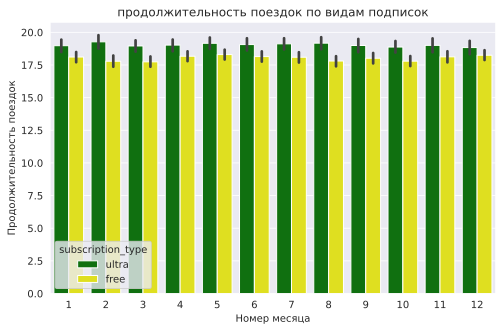

In [46]:
ax = sns.barplot(x = 'month',
            y = 'duration',
            hue = "subscription_type",
            data = users_merged_all,
            palette = ['green', 'yellow'])
ax.set_title('продолжительность поездок по видам подписок')
ax.set(xlabel='Номер месяца', ylabel='Продолжительность поездок');

##### Вывод

Проверили гипотезу, отвергли гипотезу о том, что время поездки пользователей на тарифе ultra равно времени поездки пользователей на тарифе free. Таким образом пользователи с подпиской статиcтически значимо совершают более длительные поездки чем пользователи без подписки. Визуализация данных и расчитанные показатели косвенно это подтверждают.

 6.2 
 Расстояние одной поездки в 3130 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 3130 метров? Проверьте гипотезу и сделайте выводы.

Нулевая гипотеза H_0: Расстояние (distance) пользователей на подписке ultra = 3130 метров

Альтернативная гипотеза H_1: Расстояние (distance) пользователей на подписке ultra > 3130 метров


In [47]:


target_value= 3130
alpha = 0.05
results = st.ttest_1samp(
    users_with_subscription.distance, 
    target_value,
      alternative='greater')
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу ') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу 


### Вывод
С вероятностью в 92 процента по данным теста значения полученные в выборке соответствует гипотезе что  расстояние, которое в среднем проезжают пользователи с подпиской за поездку, статистически значимо не отличается от оптимального расстояния 3130 метров



6.3. Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

In [48]:
revenue_with_subscription= users_merged_all_pivot.query('subscription_type=="ultra"')['revenue']
revenue_with_subscription

user_id  month
1        1        451.0
         4        241.0
         8        475.0
         10       391.0
         11       535.0
                  ...  
699      6        301.0
         8        469.0
         9        385.0
         10       295.0
         12       355.0
Name: revenue, Length: 4533, dtype: float64

In [49]:
revenue_without_subscription= users_merged_all_pivot.query('subscription_type!="ultra"')['revenue']
revenue_without_subscription

user_id  month
700      1        170.0
         2        962.0
         3        202.0
         4        178.0
         6        332.0
                  ...  
1534     6        308.0
         8        484.0
         9        234.0
         11       824.0
         12       178.0
Name: revenue, Length: 6767, dtype: float64

In [50]:

#H_0: Выручка (revenue_per_month) пользователей на подписке ultra = выручка (revenue_per_month) пользователей на подписке free

#H_1: Выручка (revenue_per_month) пользователей на подписке ultra > выручка (revenue_per_month) пользователей на подписке free
alpha = 0.05 # уровень статистической значимости
results = st.ttest_ind(revenue_with_subscription, revenue_without_subscription, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 2.0314113674863288e-30
Отвергаем нулевую гипотезу


In [51]:
users_merged_all_pivot.query('subscription_type!="ultra"').revenue.mean()

329.3326437121324

In [52]:
users_merged_all_pivot.query('subscription_type=="ultra"').revenue.mean()

362.7921906022502

Проверили гипотезу, соответственно, мы можем утверждать, что выручка с пользователей на подписке ultra превышает выручку с пользователей на подписке free

Также для того чтобы убедится посчитаем показатели для пользователей с подпиской и без

In [53]:
len(users_merged_all.query('subscription_type=="ultra" and distance>3130'))/len(users_merged_all.query('subscription_type=="ultra" '))

0.5153846153846153

In [54]:
users_merged_all.query('subscription_type=="ultra"').distance.mean()

3115.4453880370247

In [55]:
len(users_merged_all.query('subscription_type!="ultra" and distance>3130'))/len(users_merged_all.query('subscription_type!="ultra" '))

0.49080449751590693

In [56]:
users_merged_all.query('subscription_type=="ultra"').distance.median()

3148.6372291760854

In [57]:
users_merged_all.query('subscription_type!="ultra"').distance.mean()

3028.3742391936416

In [58]:
users_merged_all.query('subscription_type!="ultra"').distance.median()

3102.0830248287657

In [59]:
users_merged_all_pivot.query('subscription_type=="ultra"').revenue.sum()

1644537.0

In [60]:
users_merged_all_pivot.query('subscription_type!="ultra"').revenue.sum()

2228594.0

Рассчитанные значения подтверждают сделанные выводы

6.4. Представьте такую ситуацию: техническая команда сервиса обновила сервера,
    с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого 
    количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого 
    пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для 
    проверки этой гипотезы?

 ##### Ответ:
 scipy.stats.ttest_rel()
Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python , применим метод scipy.stats.ttest_rel()
Гипотезы будут сформулированы так:
H0 : μ1 = μ2
H1 :  μ2 <μ1 где  μ1 , μ2 — средние значения до и после изменения.


 ##### Общий вывод
Были загружены  данные , столбец `date` был сразу считан как дата  , проверены на пропуски и дубликаты,которые были затем удалены . Затем был добавлен  столбец `month` с номером месяца.

Далее был проведен  исследовательский анализ данных:

В ходе работы были обнаружены аномальные поездки где время одинаковое 0.5 секунды, а дистанция довольно значительная. Выбросы были удалены.
Было выявлено что количество пользователей по городам распределено более менее равномерно.Количество пользователей с подпиской и без более менее равномерно. Пользователей, использующих бесплатную подписку чуть больше - ~ 54% от общего числа пользователей процент пользователей с платной подпиской ~46%. Большая часть пользователей попадает в промежуток от 20 до 30 лет.
Большая часть пользователей попадает в промежуток от 2.5 км до 4 км.
самые короткие поездки - по пол минуты. Скорее всего являются выбросом , причиной таких поездок может быть либо техническая неисравность самоката либо какая то проблема с выгрузкой данных. Большая часть пользователей попадает в промежуток 13 - 22 минут.
Затем был создан новый датафрейм с агрегированными данными `users_merged_all_pivot` на основе датафрейма с объединенными данными `users_merged_all`.  Было найдено суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Также был создан столбец с помесячной выручкой, которую принес каждый пользователь.
Дальше визуализировали информацию о расстоянии и времени поездки для пользоватей каждого тарифа.
У бесплатного тарифа среднее время поездки несколько меньше чем  у платного а расстояние наоборот больше. Так у бесплатного тарифа время поездки составляет от 10 до 30 минут, и пользователи проезжают от 2 до 6 км. А у платного тарифа время поездки  составляет от 15 до 25 минут. И очень много пользовтаелей проезжают близко  к 3 км , что является оптимальным для износа самоката 

Далее были проверены  гипотезы:

- 1. Проверили гипотезу что время поездки пользователей на тарифе `ultra` равно времени поездки пользователей на тарифе `free`, отвергли гипотезу. Таким образом пользователи с подпиской статиcтически значимо совершают более длительные поездки чем пользователи без подписки. Визуализация данных и расчитанные показатели косвенно это подтверждают.
- 2. Пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку
С вероятностью в 92 процента по данным теста значения полученные в выборке соответствует гипотезе что  расстояние, которое в среднем проезжают пользователи с подпиской за поездку, статистически значимо не отличается от оптимального расстояния 3130 метров.
- 3. Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки
Отвергли нулевую гипотезу. Таким образом мы можем утверждать, что выручка с пользователей на подписке `ultra` превышает выручку с пользователей на подписке `free`

#### Шаг 7. Распределения